#BBVA debt classification
This is the third model we'll use for the debt classification of BBVA.

First we import some libraries.

In [ ]:
from google.colab import drive # to mount drive files
import pandas as pd # for dataframes
import numpy as np # for numerical processes
import matplotlib.pyplot as plt # for graphs
from sklearn.metrics import mean_squared_error

Second we import the discounts base, correct the data types and clean it.

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_activities(no_pilot).csv')
base.inicio_programa = pd.to_datetime(base.inicio_programa,format='%Y-%m-%d',errors='coerce') # errors in cast will be NaT
base.ultimo_pago = pd.to_datetime(base.ultimo_pago,format='%Y-%m-%d',errors='coerce')
base.executed_date = pd.to_datetime(base.executed_date,format='%Y-%m-%d',errors='coerce')
base[['bank_reference','debt_id','banco','num_tarjeta']] = base[['bank_reference','debt_id','banco','num_tarjeta']].astype(str) #simultaneous cast
base.dropna(inplace=True) #drop rows with null or NaT values
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bank_reference   21854 non-null  object        
 1   debt_id          21854 non-null  object        
 2   banco            21854 non-null  object        
 3   num_tarjeta      21854 non-null  object        
 4   deuda_resuelve   21854 non-null  float64       
 5   inicio_programa  21854 non-null  datetime64[ns]
 6   ultimo_pago      21854 non-null  datetime64[ns]
 7   executed_date    21854 non-null  datetime64[ns]
 8   pago_a_bancos    21854 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 1.5+ MB


Third, we add the bins to the base and merge them with the bin intrest rate. \\
We'll drop the wrong bank type so please specify the bank type imput and default interest rate

In [ ]:
bank_input = 'card' # input card or loan
default_interest_rate = 0.04

In [ ]:
cards = base.num_tarjeta.str.replace('\D','',regex=True)
cards_len = cards.str.len()
base['bank_type'] = np.where((cards_len >= 15)&(cards_len <= 17), 'card','loan')
base['Bin'] = cards.str[:6]
base = base[base.bank_type == bank_input]

In [ ]:
bins = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/BBVA_bins.csv')
bins['Bin'] = bins['Bin'].astype(str)
bins = bins.drop_duplicates('Bin')

In [ ]:
base = pd.merge(base, bins, on = 'Bin', how = 'left')

In [ ]:
base.tasa = base.tasa.fillna(default_interest_rate)
base[['debt_id','Bin','tasa']].sample(10)

,debt_id,Bin,tasa
2696,1172539,477214,0.0375
2036,1118289,477291,0.0375
7655,1302933,477213,0.0375
1080,857832,477291,0.0375
3242,1195167,542015,0.0375
7913,1307008,542015,0.0375
4365,1232665,477291,0.0375
6705,1281904,477213,0.0375
4555,1246124,477214,0.0375
5099,1251196,554629,0.0400


Fourth, we calculate the balance and discount. Please specify the max period of interest grow.

In [ ]:
max_period = 18 #max period of interest grow
tolerance_rate = 3 # max number of times a payment can be bigger than the original debt,
                   # bigger values will be considered mistakes
max_discount = 0.99 #discounts bigger than this will be considered mistakes

In [ ]:
base['deliq_beginning_prog'] = (base.inicio_programa.dt.year - base.ultimo_pago.dt.year)*12 + base.inicio_programa.dt.month - base.ultimo_pago.dt.month
base.deliq_beginning_prog = np.where(base.deliq_beginning_prog < 0, 0, base.deliq_beginning_prog)
base['deliq_act'] = (base.executed_date.dt.year - base.ultimo_pago.dt.year)*12 + base.executed_date.dt.month - base.ultimo_pago.dt.month
base.drop(base[base.deliq_act <0].index,inplace=True) # we drop negative periods as there must be a payment after the discount
base['aux_balance'] = np.where(base.deliq_beginning_prog > max_period, 0,
                      np.where(base.deliq_act > max_period, max_period - base.deliq_beginning_prog,
                               base.deliq_act - base.deliq_beginning_prog))
base['balance'] = base.deuda_resuelve*(1 + base.tasa)**(base.aux_balance)
base['real_discount'] = 1-base.pago_a_bancos/base.balance
base.drop(base[base.deuda_resuelve*tolerance_rate < base.pago_a_bancos].index, inplace = True)
base.drop(base[base.real_discount > max_discount].index,inplace=True)
base[['debt_id','deuda_resuelve','pago_a_bancos','tasa','deliq_act','balance','real_discount']].sample(5)

,debt_id,deuda_resuelve,pago_a_bancos,tasa,deliq_act,balance,real_discount
2072,1122886,37154.14,4580.0,0.0375,10,51748.785495,0.911496
6158,1273141,119883.13,60219.0,0.0375,4,138902.638331,0.566466
4185,1228308,23169.83,2934.0,0.0375,10,29980.549254,0.902137
3248,1195706,122439.00,22438.0,0.0375,8,164370.780355,0.863492
8626,1329551,36779.38,9841.0,0.0375,6,42614.443902,0.769069


Let's see how the discounts look!

(0.0, 22.0)

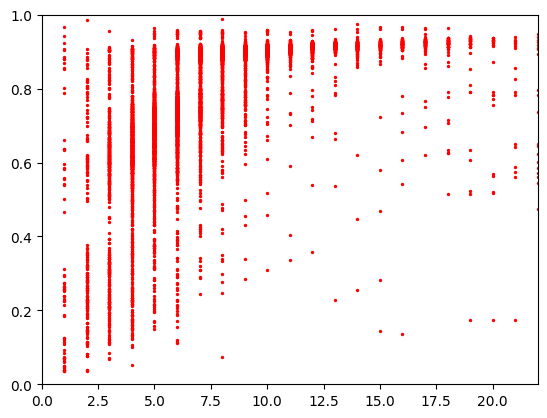

In [ ]:
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,22) # x axis size

I want to define 2 discount curves
1.   The first one will be the lowest one, for bad clients and unknown escenarios
2.   The second one will go according to the median, so it has the central shape.
3.  They will have logarthmic shape
4.  They will have a minimum (0%) and maximum (85%) value

first, lets set initial conditions


In [ ]:
size = 20
percentil_1 = 15
percentil_2 = 50
a0 = [0.18,10] # initial parameters
a1 = a0 + np.random.rand(2) # second initial parameters
iterations = 100 # num of iterations for logarithmic curve adjustment
step = 0.01 # step size for gradent descent method
max_discount = 0.85 # maximum discount
default_discount = 0.7

now i will define Gradent descent method.

In [ ]:
def grad_desc(f,x0,x1,iterations,step):
  # this is the gradent descent method for R**2 -> R functions that uses
  # numerical aproximations of the derivate of the function.
  save_x = [x0,x1] # we save the history of parameters and function evaluations
  save_f = [f(x0),f(x1)] # we save them as a python list bc is changable and ordered
  xii = x0
  xjj = x1 # j = i + 1
  it = 0
  while it < iterations and any(xii != xjj):
    xji = np.array([xjj[0],xii[1]])
    xij = np.array([xii[0],xjj[1]])
    df_dx = (f(xji)-f(xii)) / (xjj[0]-xii[0])
    df_dy = (f(xij)-f(xii)) / (xjj[1]-xii[1])
    mov = np.array([df_dx,df_dy]) * (-step)
    xii = xjj
    xjj = xjj + mov
    save_x.append(xjj)
    save_f.append(f(xjj))
    it = it + 1
  return save_x,save_f # we return the history of values, being the last one the best one

now, lets beggin to adjust the curves!

In [ ]:
c1, c2 = np.zeros(size), np.zeros(size)

for month in range(1,size):
  c1[month] = np.percentile(base[base.deliq_act == month].real_discount,percentil_1)
  c2[month] = np.percentile(base[base.deliq_act == month].real_discount,percentil_2)

cycle = 0
for curve in [c1,c2]:
  results = pd.DataFrame(columns=['add','MSE','a'])
  cycle = cycle + 1

  for add in range(5):
    def f(a,x):
      if (x-add)*a[1] <= 0:
        res = 0
      else:
        res = max(0,a[0]*np.log((x-add)*a[1]))
      return res

    def MSE(a): return mean_squared_error([f(a,x) for x in range(size)],curve)

    history_a, history_f = grad_desc(MSE,a0,a1,iterations,step)
    results.loc[add,:] = [add,history_f[-1],history_a[-1]]
  opt = results.MSE.astype('float').idxmin()
  def f(a,x):
    if (x-opt)*a[1] <= 0:
      res = 0
    else:
      res = max(0,a[0]*np.log((x-opt)*a[1]))
    return res

  a_star = results.loc[opt,'a']
  if cycle == 1:
    c1_adjusted = [f(a_star,x) for x in range(size)]
  if cycle == 2:
    c2_adjusted = [f(a_star,x) for x in range(size)]
for i in range(size):
  if c1_adjusted[i] > max_discount:
    c1_adjusted[i] = max_discount
c1_adjusted.extend(np.ones(49-size)*default_discount)
for i in range(size):
  if c2_adjusted[i] > max_discount:
    c2_adjusted[i] = max_discount
c2_adjusted.extend(np.ones(49-size)*default_discount)

(0.0, 30.0)

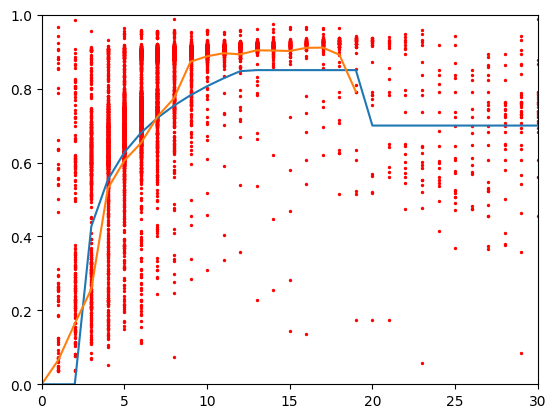

In [ ]:
plt.plot(c1_adjusted)
plt.plot(c1)
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,30) # x axis size

(0.0, 30.0)

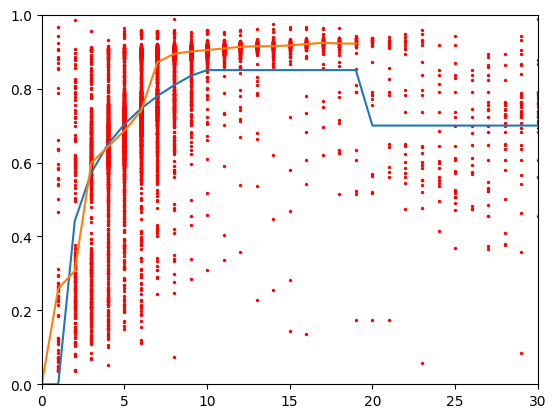

In [ ]:
plt.plot(c2_adjusted)
plt.plot(c2)
plt.scatter(base.deliq_act,base.real_discount, s = 2, color = 'red')
plt.ylim(0,1) # y axis size
plt.xlim(0,30) # x axis size

I will adjust the behavior of the clients based on the curves. If a client has a discount of 50%, no matter what delay he has, we will asume he will have a discount of 59.92% at the next month, as the first value bigger than 50% in the curve c2 is 59.92%, corresponding to month 3.

In [ ]:
debt_sale_month = 20 # aproximate month when debts start to get on sale

In [ ]:
debts = base.sort_values(['debt_id','executed_date'],ascending=[True,False]).drop_duplicates(["debt_id"]).copy()
c2_adjusted = pd.DataFrame(c2_adjusted, columns=['discount'])

for indx in debts.index:
  if debts.loc[indx,"deliq_act"] > debt_sale_month:
    debts.loc[indx,"projected_discount"] = default_discount
  elif debts.loc[indx,'real_discount'] > max_discount:
    debts.loc[indx,"projected_discount"] = max_discount
  else:
    debts.loc[indx,"projected_discount"] = c2_adjusted.discount[c2_adjusted.discount > debts.loc[indx,'real_discount']].head(1).values

debts["aux_balance_2"] = np.where(debts.deliq_beginning_prog + debts.aux_balance >= max_period,
                               debts.aux_balance,debts.aux_balance + 1)
debts["projected_balance"] = debts.deuda_resuelve*(1+ debts.tasa)**(debts.aux_balance_2)
debts["projected_payment"] = debts.projected_balance*(1 - debts.projected_discount)
debts.sample(10)

,bank_reference,debt_id,banco,num_tarjeta,deuda_resuelve,inicio_programa,ultimo_pago,executed_date,pago_a_bancos,bank_type,...,tasa,deliq_beginning_prog,deliq_act,aux_balance,balance,real_discount,projected_discount,aux_balance_2,projected_balance,projected_payment
6367,10103533002,1273720,BBVA,a4772913060373356,39215.00,2023-08-05,2023-07-06,2024-02-12,13550.00,card,...,0.0375,1,7,6,48908.106772,0.722950,0.745529,7,50742.160776,12912.391501
3302,10103453700,1196479,BBVA,a5546293000057811,87493.12,2023-04-26,2023-01-14,2023-12-07,10266.00,card,...,0.0400,3,11,8,119740.376155,0.914265,0.850000,9,124529.991202,18679.498680
6874,10103546074,1285757,BBVA,a4772133049128934,43045.49,2023-08-18,2023-06-01,2024-01-07,13329.00,card,...,0.0375,2,7,5,51744.975161,0.742410,0.745529,6,53685.411730,13661.362534
6027,10103526740,1269438,BBVA,a4772913070436417,22817.00,2023-07-31,2023-07-01,2024-02-08,3417.00,card,...,0.0375,0,7,7,29524.005672,0.884264,0.850000,8,30631.155885,4594.673383
4208,10103483021,1228643,BBVA,a4772133051296405,189775.00,2023-05-31,2023-05-05,2024-02-29,27291.00,card,...,0.0375,0,9,9,264321.170326,0.896751,0.850000,10,274233.214213,41134.982132
8773,10103591932,1333541,BBVA,a4772133052744932,54030.93,2023-10-13,2023-09-28,2024-01-12,13400.00,card,...,0.0375,1,4,3,60340.201898,0.777926,0.779911,4,62602.959469,13778.232897
3455,10103460420,1204809,BBVA,a4772143019997168,171214.26,2023-05-22,2023-03-31,2024-02-26,19140.00,card,...,0.0375,2,11,9,238469.522222,0.919738,0.850000,10,247412.129305,37111.819396
8646,10103587811,1407941,BBVA,a5420150012866632,29718.50,2024-01-10,2023-09-01,2024-02-26,8278.00,card,...,0.0375,4,5,1,30832.943750,0.731521,0.745529,2,31989.179141,8140.307755
6911,10103546805,1285497,BBVA,a4772913083247637,31322.13,2023-08-31,2023-06-24,2024-02-20,3544.51,card,...,0.0375,2,8,6,39064.288623,0.909265,0.850000,7,40529.199447,6079.379917
7650,10103563211,1301564,BBVA,a4772913067433377,23831.38,2023-08-31,2023-07-01,2024-02-08,2555.00,card,...,0.0375,1,7,6,29721.985913,0.914037,0.850000,7,30836.560384,4625.484058
